In [1]:
from matplotlib import pyplot as plt
import argparse
import numpy as np
import time

In [2]:
class RNNet(object):
    def __init__(self, input_size, hidden_dim=200, temp=1.0):
        
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.temp = temp

        self.Wxh = np.random.uniform(-np.sqrt(1. / input_size), np.sqrt(1. / input_size), size=(self.hidden_dim, self.input_size))
        self.Whh = np.random.uniform(-np.sqrt(1. / hidden_dim), np.sqrt(1. / hidden_dim), size=(self.hidden_dim, self.hidden_dim))
        self.Who = np.random.uniform(-np.sqrt(1. / hidden_dim), np.sqrt(1. / hidden_dim), size=(self.input_size, self.hidden_dim))

    def forward(self, inputs, h_t_1):
        
        hidden_states = {}
        out_probs = {}
        hidden_states[-1] = np.copy(h_t_1)
        
        for t in range(0, len(inputs)):
            iter_inputs = np.zeros(self.input_size)
            iter_inputs[inputs[t]] = 1
            iter_inputs = iter_inputs.reshape(-1, 1)
            hidden_states[t] = np.tanh(np.matmul(self.Wxh, iter_inputs) + np.matmul(self.Whh, hidden_states[t - 1]))
            raw_outputs = np.matmul(self.Who, hidden_states[t])
            out_probs[t] = self.softmax(raw_outputs, self.temp)
            
        return hidden_states, out_probs
    
    def backward(self, inputs, targets, h_t_1):
        
        hidden_states, char_probs = self.forward(inputs, h_t_1)
        cur_loss = self.loss(char_probs, targets)
        gradient_xh, gradient_hh, gradient_ho = np.zeros(self.Wxh.shape), np.zeros(self.Whh.shape), np.zeros(self.Who.shape)
        derv_timestep = np.zeros(hidden_states[0].shape)
        
        for t in range(len(inputs) - 1, 0, -1):
            out_delta = np.copy(char_probs[t])
            out_delta[targets[t]] -= 1
            gradient_ho += np.matmul(out_delta, hidden_states[t].T)
            derv_tanh = (1 - hidden_states[t] * hidden_states[t])
            do_dh = derv_tanh * (np.matmul(self.Who.T, out_delta) + derv_timestep)

            iter_inputs = np.zeros(self.input_size)
            iter_inputs[inputs[t]] = 1
            iter_inputs = iter_inputs.reshape(-1, 1)
            gradient_xh += np.matmul(do_dh, iter_inputs.T)
            gradient_hh += np.matmul(do_dh, hidden_states[t - 1].T)
            derv_timestep = np.matmul(self.Whh.T, do_dh)

        gradient_xh = gradient_xh.clip(min=-2, max=2)
        gradient_hh = gradient_hh.clip(min=-2, max=2)
        gradient_ho = gradient_ho.clip(min=-2, max=2)

        return cur_loss, (gradient_xh, gradient_hh, gradient_ho), hidden_states[len(inputs) - 1]

    def loss(self, pred_probs, targets):
        loss = 0.0
        for t in range(0, len(targets)):
            loss += -np.log(pred_probs[t][targets[t]])
        return loss

    def predict(self, seed, hidden_state, n, is_max_prob=True):
        
        input = np.zeros(self.input_size)
        input[seed] = 1
        input = input.reshape(-1, 1)
        chars = []
        for t in range(0, n):
            hidden_state = np.tanh(np.matmul(self.Wxh, input) + np.matmul(self.Whh, hidden_state))
            out = np.matmul(self.Who, hidden_state)
            out = self.softmax(out)
            if not is_max_prob:
                char = np.random.choice(list(range(self.input_size)), p=out.ravel())
            elif is_max_prob:
                char = np.argmax(out.reshape(-1))

            chars.append(char)
            input = np.zeros(self.input_size)
            input[char] = 1
            input = input.reshape(-1, 1)
        return chars
    
    def softmax(self, w, t=1.0):
        e = np.exp(np.array(w) / t)
        dist = e / np.sum(e)
        return dist

In [3]:
def char_to_encode(char_list):
    char_encoding = []
    for c in char_list:
        char_encoding.append(ord(c))
    return char_encoding

def encode_to_char(enc_list):
    char_list = []
    for e in enc_list:
        char_list.append(chr(e))
    return char_list

In [4]:
with open('data/1.txt', 'r', encoding='ascii', errors='ignore') as f:
    text  = f.read()
text_len = len(text)
encoded_text = char_to_encode(text)

In [5]:
def runRNN(hidden_dim,seq_len,temp,lr,is_random_init=True, max_prob = True):
    #hidden_dim=250
    #seq_len =8
    #temp=0.35
    #lr= 0.001
    #is_random_init=True
    epochs=100
    epoch = 0
    epoch_break_point = 20
    iters = 0
    ptr = 0

    rnn = RNNet(256, hidden_dim, temp)

    if not is_random_init:
        hidden_state = np.zeros(hidden_dim).reshape(-1, 1)
    if is_random_init:
        hidden_state = np.random.randn(hidden_dim).reshape(-1, 1)

    losses = []
    epoch_time = []
    print('For Temperature:{}\nHidden units:{}\nSequence Length:{}\n'.format(temp,hidden_dim,seq_len))
    print('Epoch\tTime(sec)\tLoss\n')
    start = time.clock()
    while epoch != epochs:
        if ptr + seq_len + 1 >= text_len:
            time_lapse = time.clock() - start
            epoch_time.append(time_lapse)
            start = time.clock()
            inputs = encoded_text[ptr : -1]
            targets = encoded_text[ptr + 1 : ]
            ptr = 0
            print('{}\t{:.2f}\t\t{:.3f}'.format(epoch, time_lapse,loss[0]))
            if not is_random_init:
                hidden_state = np.zeros(hidden_dim).reshape(-1, 1)
            if is_random_init:
                hidden_state = np.random.randn(hidden_dim).reshape(-1, 1)
                
                
            if  epoch != 0 and (epoch + 1) % epoch_break_point == 0:
                print('Epoch Breakpoint: {}'.format(epoch))
                encode_generated = rnn.predict(seed=char_to_encode(['a'])[0], hidden_state=hidden_state, n=100, is_max_prob = max_prob)
                predicted_text = encode_to_char(encode_generated)
                predicted_text = ''.join(predicted_text)
                print(predicted_text,'\n')
            epoch += 1

        else:
            inputs = encoded_text[ptr : ptr + seq_len]
            targets = encoded_text[ptr + 1 : ptr + seq_len + 1]


        loss, gradients, hidden_state = rnn.backward(inputs=inputs, targets=targets, h_t_1=hidden_state)
        if ptr == 0:
            losses.append(loss)
        iters += 1

        '''if iters % 1000 == 1:
            print('loss at iteration {} = {}'.format(iters, loss))'''

        rnn.Wxh -= lr * (gradients[0] + 0.0001 * rnn.Wxh)
        rnn.Whh -= lr * (gradients[1] + 0.0001 * rnn.Whh)
        rnn.Who -= lr * (gradients[2] + 0.0001 * rnn.Who)

        ptr += seq_len
    return losses, epoch_time

In [6]:
def plot_fig(losses):
    plt.figure(figsize=(16, 12))
    plt.title("Training Loss Vs Epochs")
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('training loss')
    plt.savefig('output/loss_vs_epoch.png')

### 4 b (i)
#### Training Procedure

For Temperature:1

Hidden units:300

Sequence Length:20

For Temperature:1
Hidden units:300
Sequence Length:20

Epoch	Time(sec)	Loss

0	30.87		64.360
1	30.43		60.806
2	30.71		57.725
3	30.57		54.363
4	30.48		51.131
5	30.76		48.450
6	30.74		46.394
7	30.53		45.056
8	30.65		43.960
9	30.38		42.918
10	30.93		41.966
11	31.05		41.201
12	30.60		40.647
13	30.71		40.249
14	30.79		39.916
15	30.81		39.615
16	30.42		39.348
17	30.62		39.153
18	30.89		39.074
19	30.53		38.975
Epoch Breakpoint: 19
dk Higher buind wath ustor? doray eavee mithin, I bo neruce of
AnsatioC in a man were mort ti't eagn 

20	30.93		38.508
21	30.71		37.414
22	30.87		36.180
23	30.78		35.882
24	30.40		35.998
25	30.69		35.549
26	30.83		34.207
27	30.62		35.222
28	30.69		37.335
29	30.93		36.878
30	30.79		39.419
31	30.64		38.279
32	30.65		34.516
33	30.67		37.812
34	30.87		36.719
35	30.78		38.745
36	30.59		39.783
37	30.74		39.469
38	30.69		36.461
39	30.79		36.782
Epoch Breakpoint: 39
dd!,
and ulting wher sead mirinions cibse; I Pins. I co beriS m
Sives minber
deainer Ds, a ke ford f 

40	31

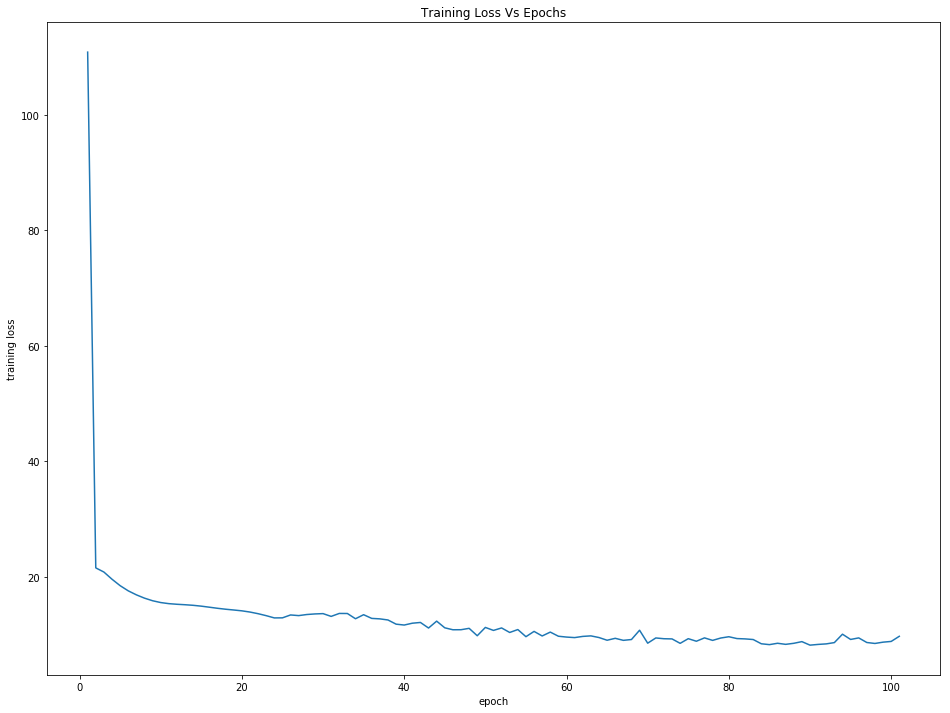

In [8]:
losses, times_taken = runRNN(hidden_dim=300,seq_len=20,temp=1,lr=1e-3,is_random_init=False, max_prob = False)
plot_fig(losses)

### 4 a (ii) Breaking Points (20, 40, 60, 80, 100)

For Temperature:3
Hidden units:300
Sequence Length:20

Epoch	Time(sec)	Loss

0	29.91		66.895
1	29.10		64.909
2	36.49		63.307
3	34.07		62.052
4	30.71		59.959
5	30.31		55.722
6	30.55		52.555
7	30.34		50.005
8	30.50		46.663
9	30.62		43.816
10	30.77		42.407
11	27.05		42.060
12	26.80		41.704
13	26.83		41.389
14	30.50		40.094
15	30.23		40.179
16	30.32		38.669
17	30.47		43.310
18	31.02		42.135
19	32.78		38.758
Epoch Breakpoint: 19
dk7É¹¬ªÂ¹Â¹ªÂ¹Â¹¹4§§ÂÂ4§¹¹ÂÂ#¹4§Â¹¹Â§\§Â¹Â§¹¹§Â¹¹Â§\¹Â§¹Â§\¹¹Â§\¹¹Â§¹Â§\¹ÂÂ§¹ÂÂ 

20	31.46		39.510
21	31.31		38.881
22	31.56		41.919
23	30.43		38.990
24	30.59		41.000
25	30.34		43.493
26	30.92		41.654
27	30.48		37.543
28	34.35		40.084
29	32.70		39.507
30	34.65		39.146
31	31.54		42.106
32	31.09		40.206
33	31.34		36.528
34	31.07		42.461
35	31.00		41.725
36	31.11		39.615
37	31.22		42.120
38	31.50		37.015
39	30.89		42.612
Epoch Breakpoint: 39
r grouth I he was a bear and the rope and the rope and the rope and the rope and the rope and the ro 

40	31

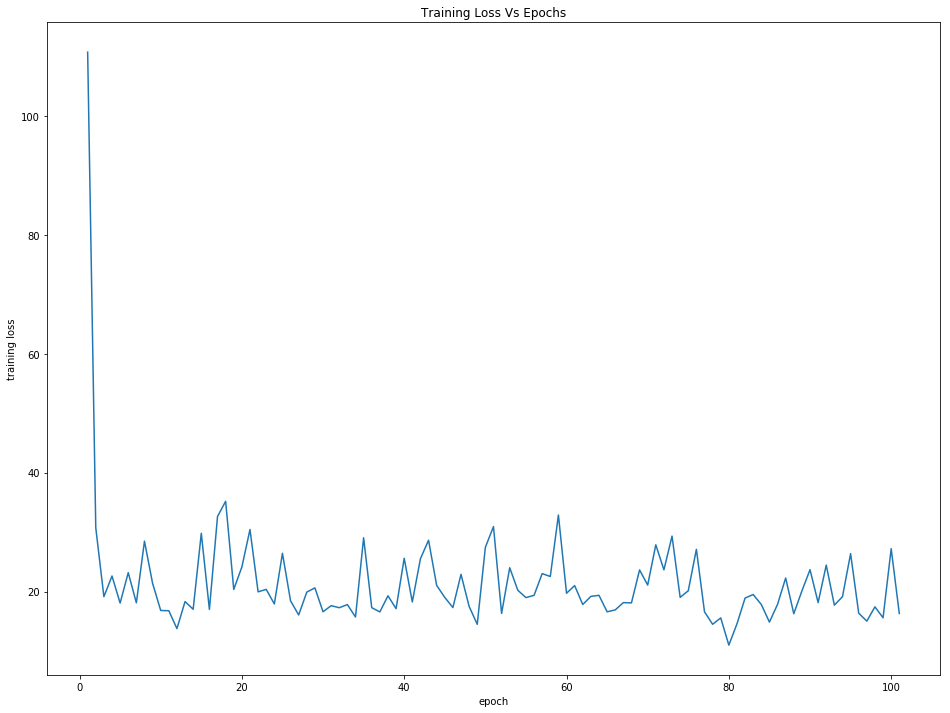

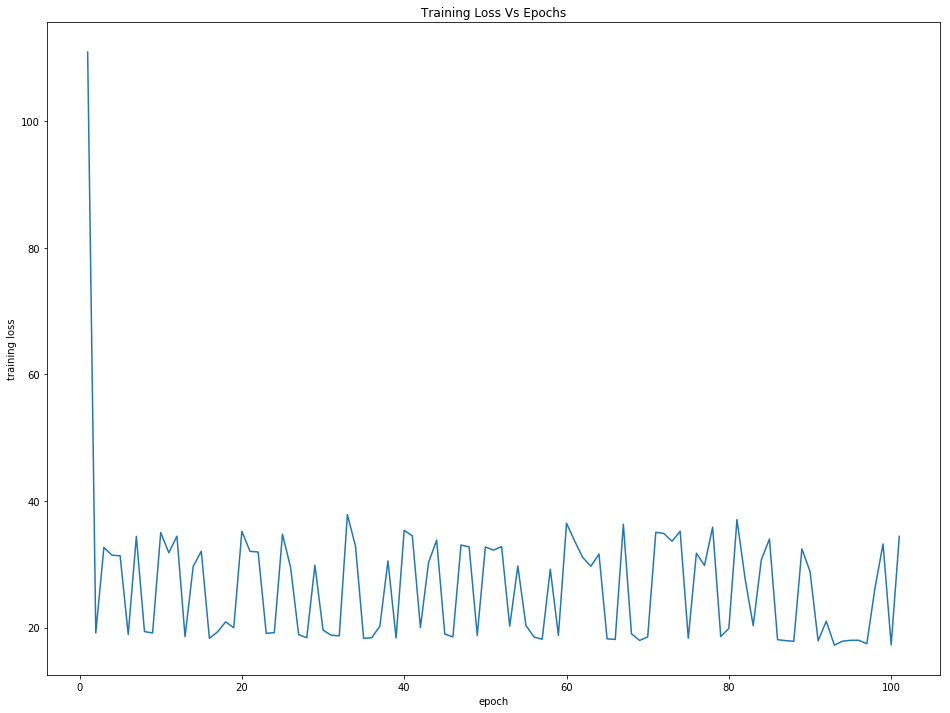

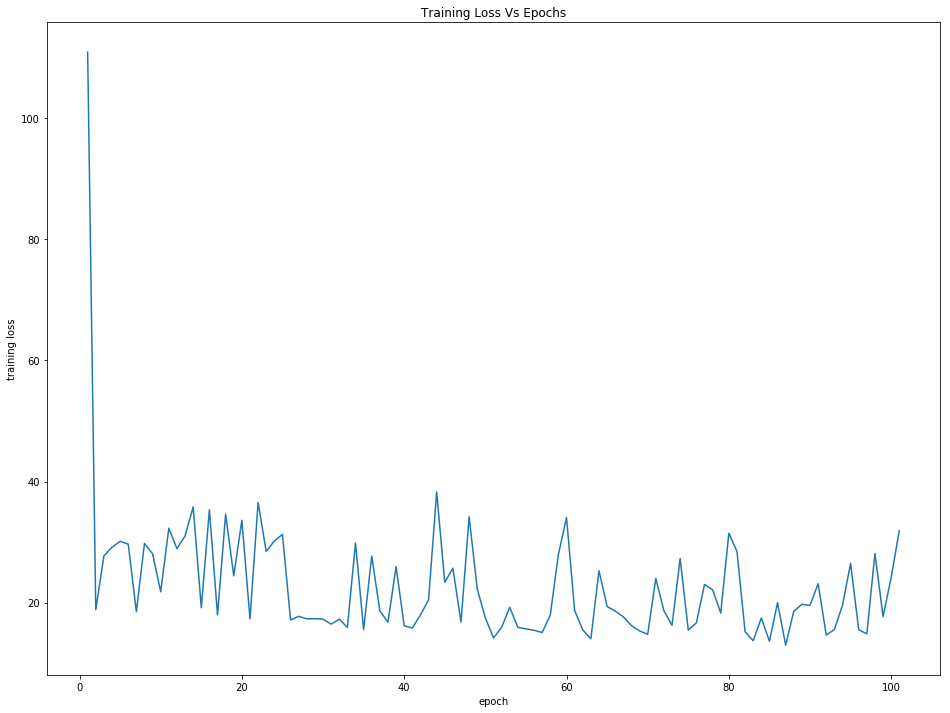

In [7]:
temps = [3, 12, 25]
for temp in temps:
    losses, times_taken = runRNN(hidden_dim=300,seq_len=20,temp=temp,lr=1e-3,is_random_init=True, max_prob = True)
    plot_fig(losses)

### Tweaking Number of Hidden Units

#### double the hidden dimensions

For Temperature:5
Hidden units:600
Sequence Length:20

Epoch	Time(sec)	Loss

0	290.46		67.289
1	289.96		66.662
2	290.34		64.454
3	289.44		61.276
4	288.72		59.016
5	288.62		56.977
6	290.07		53.552
7	291.71		50.466
8	290.01		47.484
9	288.97		44.636
10	289.20		43.204
11	289.17		42.592
12	297.41		42.417
13	313.84		41.209
14	307.66		39.239
15	291.20		42.627
16	309.70		45.143
17	291.18		41.181
18	290.62		43.218
19	292.54		45.475
Epoch Breakpoint: 19
ngh I his the hist an the rian the ripreather a dith the rian the ripreather a dith the rian the rip 

20	292.02		39.697
21	293.81		44.972
22	289.92		43.936
23	290.73		47.088
24	289.62		46.300
25	291.91		43.964
26	291.67		45.034
27	290.78		43.710
28	290.13		48.551
29	289.44		47.021
30	312.10		44.582
31	291.93		49.556
32	501.22		43.058
33	660.03		48.953
34	513.88		43.876
35	322.57		46.743
36	321.58		47.019
37	320.82		46.735
38	333.27		49.166
39	344.25		49.655
Epoch Breakpoint: 39
EIxÌÅ¨ÄÌÄÌÌÄÄÄá¨ÄáÌÌÌÄÌáÄáÄÄáÄÌÄÄáÄÌáÌáÄÌáÄÌÄÄáÄÌÄÌáÄÌÄÄáÄÌáÌá

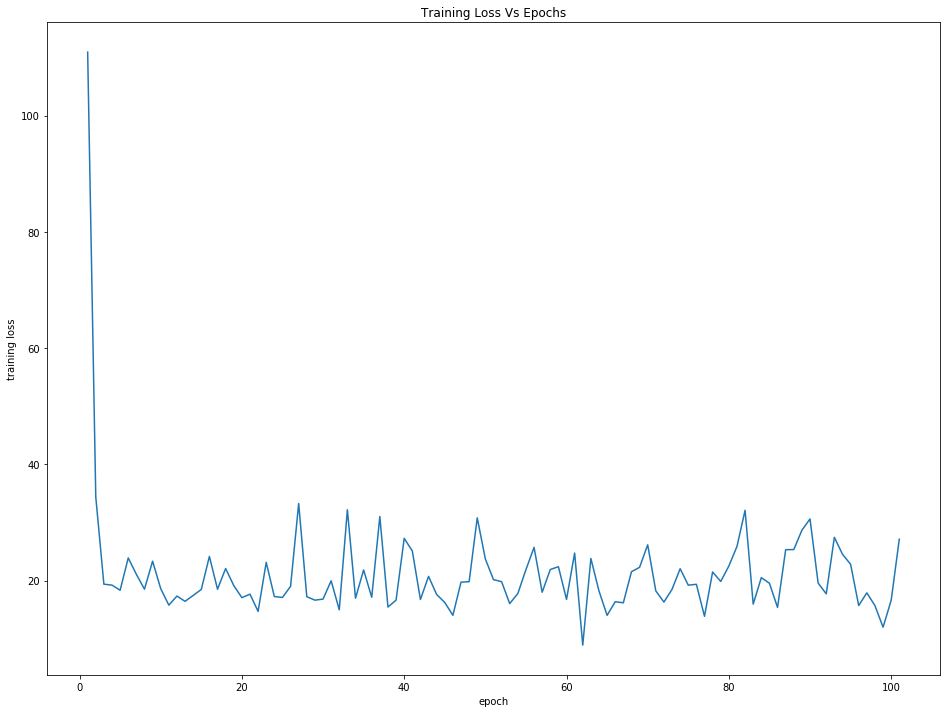

In [11]:
losses, times_taken = runRNN(hidden_dim=600,seq_len=20,temp=5,lr=1e-3,is_random_init=True, max_prob = True)
plot_fig(losses)

#### Halving the hidden dimensions

For Temperature:5
Hidden units:150
Sequence Length:20

Epoch	Time(sec)	Loss

0	14.16		66.938
1	14.06		67.150
2	13.93		66.993
3	13.90		65.758
4	13.97		65.407
5	14.00		65.120
6	14.11		64.040
7	14.61		63.042
8	14.17		61.756
9	14.03		60.884
10	13.91		58.221
11	14.01		56.605
12	14.08		55.408
13	13.95		53.713
14	14.04		50.321
15	13.94		49.331
16	13.94		47.376
17	14.30		45.777
18	14.74		44.660
19	14.23		44.127
Epoch Breakpoint: 19
Thed, I the and and and and and and and and and and and and and and and and and and and and and and  

20	14.19		44.108
21	14.14		44.441
22	14.14		47.930
23	14.22		44.065
24	14.07		43.477
25	14.26		42.902
26	14.20		42.525
27	15.01		43.403
28	15.07		41.307
29	14.72		41.456
30	14.02		39.535
31	14.19		40.723
32	14.00		43.326
33	14.23		40.831
34	13.95		42.899
35	14.07		39.175
36	14.03		41.079
37	14.02		38.530
38	14.44		39.735
39	14.51		38.075
Epoch Breakpoint: 39
laver a mear the last that the ancent of the list that the andentle a singer of the last that the an 

40	14

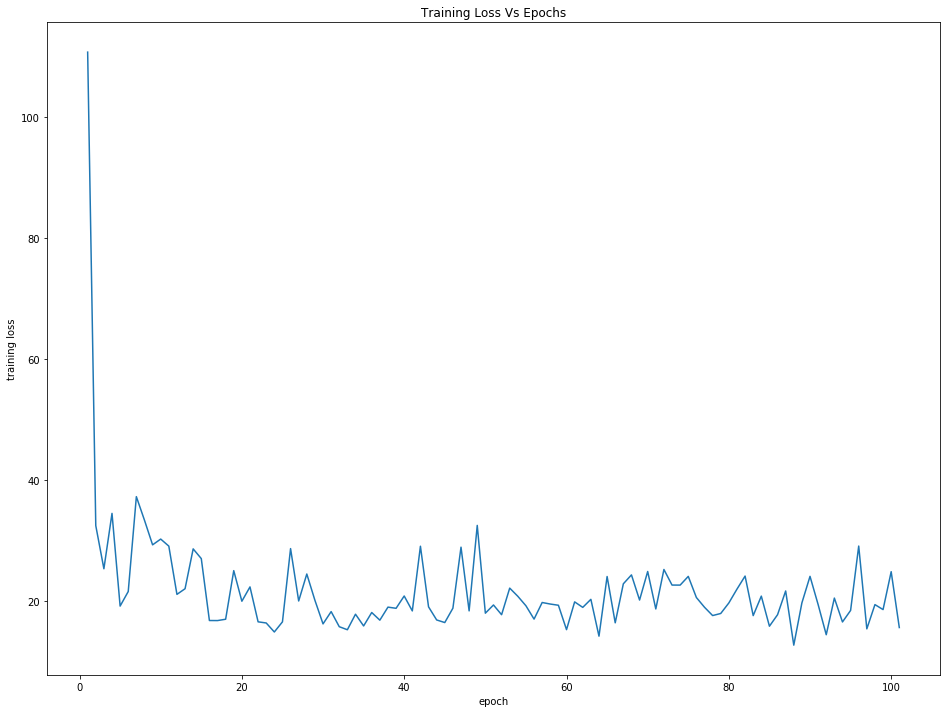

In [12]:
losses, times_taken = runRNN(hidden_dim=150,seq_len=20,temp=5,lr=1e-3,is_random_init=True, max_prob = True)
plot_fig(losses)

### Tweaking Sequence Length
#### double the seq length

For Temperature:5
Hidden units:300
Sequence Length:40

Epoch	Time(sec)	Loss

0	44.47		120.103
1	46.29		119.704
2	45.69		117.333
3	45.75		115.526
4	43.57		114.620
5	42.38		114.137
6	42.67		110.165
7	42.82		104.737
8	42.22		98.532
9	42.89		94.191
10	42.85		92.967
11	42.69		89.595
12	42.17		87.941
13	42.33		85.473
14	44.74		82.711
15	42.63		82.612
16	42.40		81.712
17	43.64		81.412
18	43.24		80.419
19	42.46		82.685
Epoch Breakpoint: 19
gd, Ix¤Ø»ÜÙÁç*öçÂ¥ö»ö»¥ö*¥öö*öç¥ö»¥ö»*çö» 

20	42.57		82.008
21	45.47		84.132
22	42.50		80.015
23	42.06		82.112
24	42.31		82.432
25	43.31		77.697
26	42.11		81.592
27	42.39		81.153
28	43.47		82.560
29	42.67		83.213
30	45.21		79.936
31	43.58		78.170
32	43.94		75.584
33	42.94		82.292
34	42.94		72.843
35	43.08		75.268
36	43.66		80.546
37	43.66		80.982
38	43.92		73.926
39	49.25		73.342
Epoch Breakpoint: 39
dd,
WWvexphith;
TWÈ¿0¸0¿0x0¿0000x0000Áå»¾x0>å0å0åå0ÁåxÁå0Áåxååxåå0å¿xåå0Á¿xå¿x

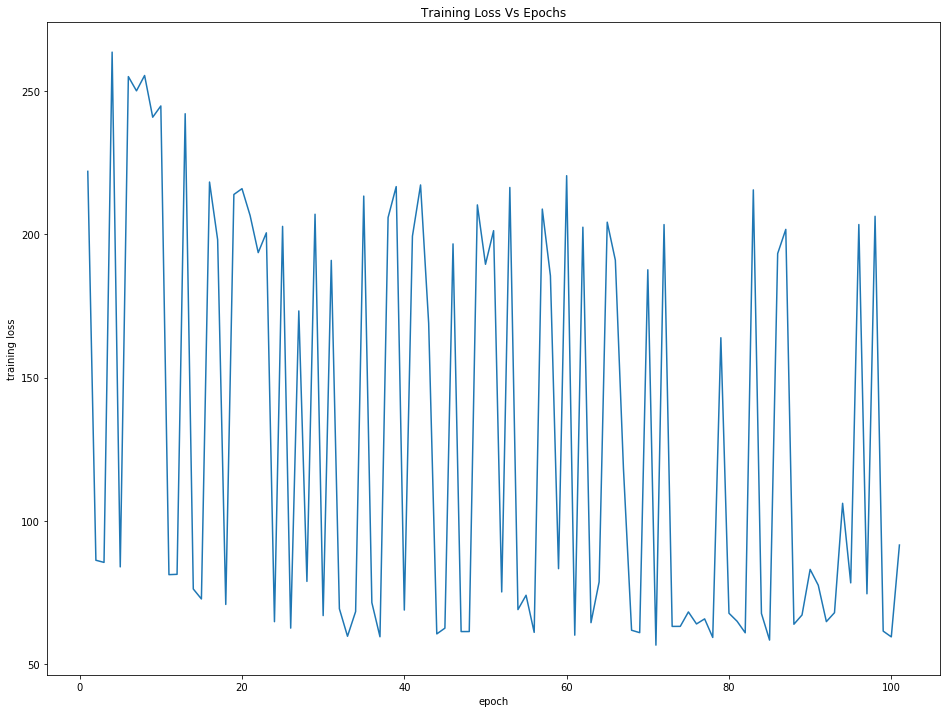

In [13]:
losses, times_taken = runRNN(hidden_dim=300,seq_len=40,temp=5,lr=1e-3,is_random_init=True, max_prob = True)
plot_fig(losses)

#### half the seq length

For Temperature:5
Hidden units:300
Sequence Length:10

Epoch	Time(sec)	Loss

0	41.91		28.861
1	39.90		28.829
2	39.90		28.529
3	40.14		28.182
4	41.48		28.077
5	39.77		26.910
6	39.64		27.257
7	41.29		28.163
8	43.36		27.630
9	42.59		26.773
10	40.78		26.226
11	42.67		25.900
12	42.19		26.599
13	42.68		25.913
14	42.68		26.122
15	45.84		24.275
16	42.80		22.943
17	44.21		25.611
18	44.62		24.848
19	43.42		23.782
Epoch Breakpoint: 19
dgwx¥Ã	~¶ ½½¶½*î½½½½½½½½½½½½½½½½½½½½½½½½½½½½½½½½½½½½½½½½½½½½½½½[½½è½½½½~½½½~½î½½ 

20	41.59		22.117
21	42.48		23.364
22	43.92		22.115
23	43.56		22.973
24	45.51		22.976
25	44.86		21.239
26	44.87		21.581
27	43.19		24.764
28	44.09		23.160
29	44.78		23.617
30	43.34		19.432
31	43.53		22.917
32	41.14		19.925
33	43.16		23.450
34	42.58		18.130
35	44.84		22.158
36	44.51		24.408
37	46.71		23.972
38	42.59		22.190
39	42.05		21.600
Epoch Breakpoint: 39
sdexthen the reath the reath the reath the reath the reath the reath the reath the reath the reath t 

40	41

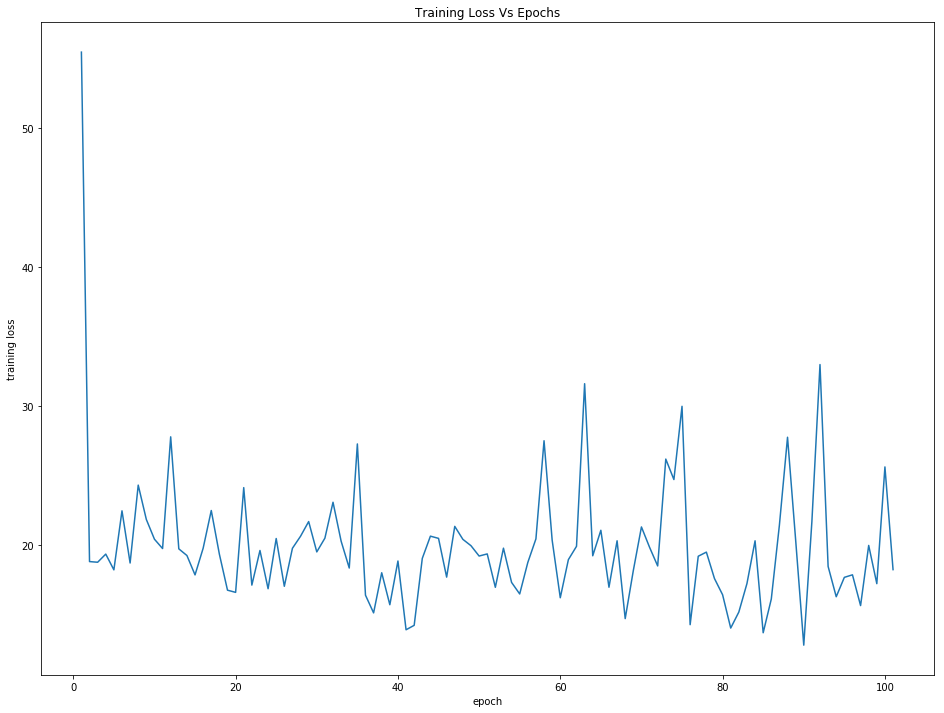

In [14]:
losses, times_taken = runRNN(hidden_dim=300,seq_len=10,temp=5,lr=1e-3,is_random_init=True, max_prob = True)
plot_fig(losses)